In [6]:
# train_with_gtFine.py

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from PIL import Image
import numpy as np
from tqdm import tqdm

# 🔧 Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🟢 Using GPU: {torch.cuda.get_device_name(0)}") if torch.cuda.is_available() else print("🟡 Using CPU")

batch_size = 4
num_classes = 19
epochs = 3
resize = (256, 512)
checkpoint_path = 'deeplabv3_cityscapes_fine.pth'

# 🗺️ Dataset ufficiale con gtFine
class CityscapesFineDataset(Dataset):
    def __init__(self, root, split='train', transform=None, resize=(256,512)):
        self.img_dir = os.path.join(root, 'leftImg8bit', split)
        self.label_dir = os.path.join(root, 'gtFine', split)
        self.transform = transform
        self.resize = resize
        self.images = []
        self.labels = []

        for city in os.listdir(self.img_dir):
            for fn in os.listdir(os.path.join(self.img_dir, city)):
                if fn.endswith('_leftImg8bit.png'):
                    self.images.append(os.path.join(self.img_dir, city, fn))
                    self.labels.append(
                        os.path.join(self.label_dir, city,
                                     fn.replace('_leftImg8bit.png', '_gtFine_labelTrainIds.png'))
                    )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('RGB')
        lbl = Image.open(self.labels[idx])
        img = img.resize((self.resize[1], self.resize[0]), Image.BILINEAR)
        lbl = lbl.resize((self.resize[1], self.resize[0]), Image.NEAREST)
        if self.transform:  
            img = self.transform(img)
        lbl = torch.from_numpy(np.array(lbl)).long()
        return img, lbl

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_ds = CityscapesFineDataset(root='datasets/realcityscapes', split='train', transform=transform, resize=resize)
train_ds.images = train_ds.images
train_ds.labels = train_ds.labels

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # <= PER ORA DISATTIVA
    pin_memory=True,
    persistent_workers=False  # <= QUESTO PUÒ BLOCCARE SU WINDOWS
)


# 🧠 Modello + ottimizzatore + AMP
model = deeplabv3_resnet50(pretrained=False, num_classes=num_classes).to(device)
model = model.to(memory_format=torch.channels_last)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)
scaler = torch.cuda.amp.GradScaler()

# 🔁 Checkpoint
start_epoch = 0
if os.path.exists(checkpoint_path):
    ck = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ck['model'])
    optimizer.load_state_dict(ck['optimizer'])
    scaler.load_state_dict(ck['scaler'])
    start_epoch = ck['epoch'] + 1
    print(f"🔁 Ripartendo da epoca {start_epoch}")

# 🏁 Training
for epoch in range(start_epoch, start_epoch + epochs):
    model.train()
    running_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{start_epoch+epochs}")
    for images, masks in loop:
        images = images.to(device, memory_format=torch.channels_last, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        with torch.cuda.amp.autocast():
            out = model(images)['out']
            loss = criterion(out, masks)
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        loop.set_postfix(loss=running_loss/(loop.n+1))

    print(f"✅ Epoca {epoch+1}: Avg Loss = {running_loss/len(train_loader):.4f}")

    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scaler': scaler.state_dict(),
        'epoch': epoch
    }, checkpoint_path)


🟢 Using GPU: NVIDIA GeForce RTX 4070


C:\Users\colam\AppData\Local\Temp\ipykernel_11624\3633016361.py:79: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\colam\AppData\Local\Temp\ipykernel_11624\3633016361.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `w

🔁 Ripartendo da epoca 35


Epoch 36/38:   0%|          | 0/744 [00:00<?, ?it/s]C:\Users\colam\AppData\Local\Temp\ipykernel_11624\3633016361.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 36/38: 100%|██████████| 744/744 [07:04<00:00,  1.75it/s, loss=0.0971]


✅ Epoca 36: Avg Loss = 0.0971


Epoch 37/38: 100%|██████████| 744/744 [07:24<00:00,  1.67it/s, loss=0.0875]


✅ Epoca 37: Avg Loss = 0.0875


Epoch 38/38: 100%|██████████| 744/744 [07:25<00:00,  1.67it/s, loss=0.0779]


✅ Epoca 38: Avg Loss = 0.0779


🟢 Using: NVIDIA GeForce RTX 4070


C:\Users\colam\AppData\Local\Temp\ipykernel_11624\2189804857.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


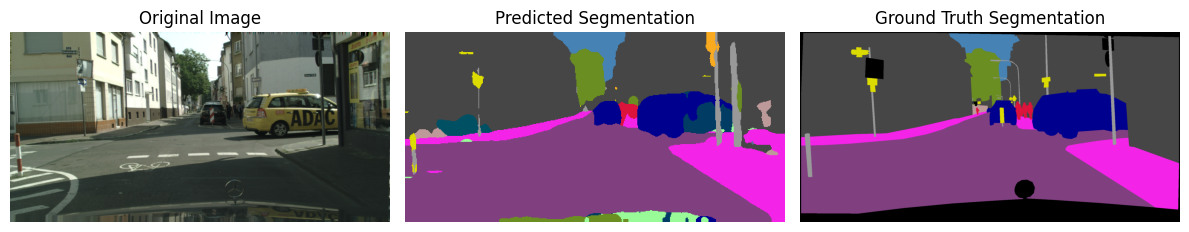

In [7]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from dataset import COLORS  # Assicurati che COLORS sia un np.array[19, 3]

# 🔧 Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{'🟢' if torch.cuda.is_available() else '🟡'} Using: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

num_classes = 19
model_path = 'deeplabv3_cityscapes_fine.pth'
image_path = 'datasets/realcityscapes/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png'
ground_image_path = 'datasets/realcityscapes/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_color.png'
resize = (256, 512)

def decode_segmap(pred):
    h, w = pred.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for label in range(num_classes):
        color_mask[pred == label] = COLORS[label]
    return color_mask

# 📦 Load model
model = deeplabv3_resnet50(pretrained=False, num_classes=num_classes).to(device)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model'])
model.eval()

# 🖼️ Load and preprocess image
image = Image.open(image_path).convert('RGB')
ground_image = Image.open(ground_image_path)


transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.ToTensor(),
])
input_tensor = transform(image).unsqueeze(0).to(device)

# 🔍 Inference
with torch.no_grad():
    output = model(input_tensor)['out']
    output = torch.nn.functional.interpolate(output, size=resize, mode='bilinear', align_corners=False)
    prediction = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
    seg_image = decode_segmap(prediction)



# 📊 Visualizzazione
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Segmentation")
plt.imshow(seg_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Ground Truth Segmentation")
plt.imshow(ground_image)
plt.axis('off')


plt.tight_layout()
plt.show()
